Heston Model implementation

In [8]:
#import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import py_vollib
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

In [9]:
# Parameters
# Simulation-dependent parameters
S0 = 100.0             # Initial asset price
T = 1.0                # Time in years (maturity)
r = 0.02               # Risk-free rate
N = 252                # Number of time steps in the simulation (daily steps over 1 year)
M = 1000               # Number of Monte Carlo simulations

# Heston model dependent parameters
kappa = 3              # Rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # Long-term mean of variance under risk-neutral dynamics (variance level)
v0 = 0.25**2           # Initial variance under risk-neutral dynamics (starting volatility squared)
rho = 0.7              # Correlation between asset returns and volatility
sigma = 0.6            # Volatility of volatility (how much volatility itself changes)


In [10]:
# Function to simulate the Heston model dynamics
def heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M):
    """
    Simulates asset prices and variance paths under the Heston model.
    
    Parameters:
    S0 (float): Initial asset price
    v0 (float): Initial variance
    rho (float): Correlation between asset returns and variance
    kappa (float): Mean reversion rate of the variance
    theta (float): Long-term mean of variance
    sigma (float): Volatility of volatility
    T (float): Time to maturity
    N (int): Number of time steps
    M (int): Number of simulations
    
    Returns:
    S (array): Simulated asset prices
    v (array): Simulated variances
    """
    # Calculate time step size
    dt = T / N
    
    # Mean and covariance for the multivariate normal distribution (correlated Brownian motions)
    mu = np.array([0, 0])
    cov = np.array([[1, rho], [rho, 1]])
    
    # Matrices to store simulated asset prices and variances
    S = np.full(shape=(N+1, M), fill_value=S0)  # Asset prices
    v = np.full(shape=(N+1, M), fill_value=v0)  # Variance paths
    
    # Generate correlated Brownian motions 
    Z = np.random.multivariate_normal(mu, cov, (N, M))

    # Loop over time steps to simulate paths
    for i in range(1, N+1):
        # Asset price dynamics: follows stochastic differential equation for Heston model
        S[i] = S[i-1] * np.exp((r - 0.5 * v[i-1]) * dt + np.sqrt(v[i-1] * dt) * Z[i-1, :, 0])
        
        # Variance dynamics: mean-reverting process (Cox-Ingersoll-Ross like model)
        v[i] = np.maximum(v[i-1] + kappa * (theta - v[i-1]) * dt + sigma * np.sqrt(v[i-1] * dt) * Z[i-1, :, 1], 0)

    return S, v

In [11]:
# Correlation values for comparison
rho_p = 0.09  # Positive low correlation
rho_n = -0.98  # Negative high correlation

# Simulate Heston model under different correlations
S_p, v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma, T, N, M)
S_n, v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma, T, N, M)


Plotting the code

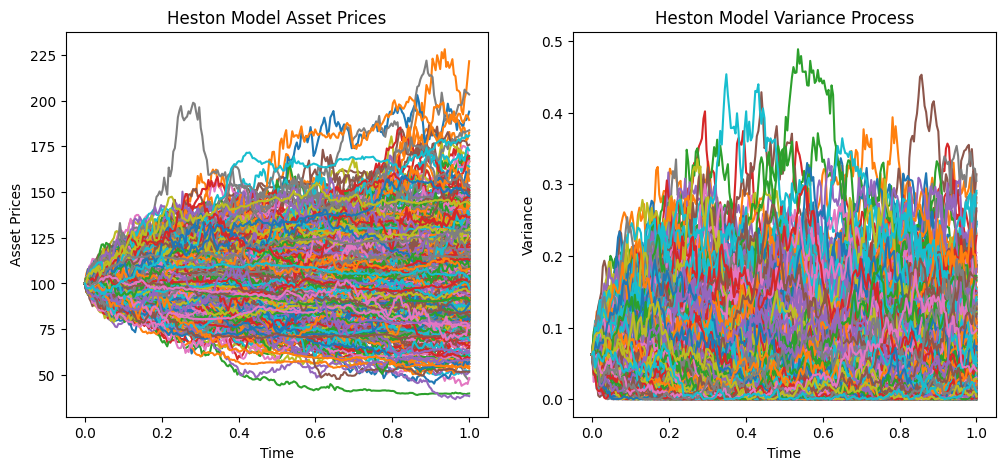

In [15]:
# Plot asset prices and variances over time for the positively correlated case
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Create two subplots
time = np.linspace(0, T, N+1)  # Time axis

# Plot asset prices over time
ax1.plot(time, S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

# Plot variance over time
ax2.plot(time, v_p)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')

# Display the plots
plt.show()

Simulate a geometric Brownian motion (GBM) process as a comparison

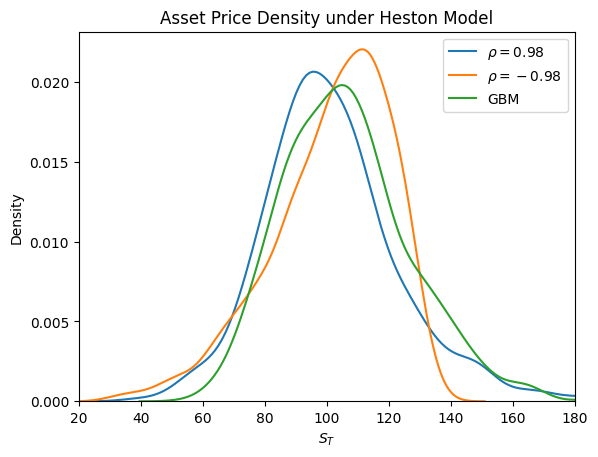

In [13]:
gbm = S0 * np.exp((r - theta**2 / 2) * 2 + np.sqrt(theta) * np.sqrt(T) * np.random.normal(0, 1, M))
# Plot the density of the asset prices at the final time step
fig, ax = plt.subplots()

# Plot for asset prices at maturity (T) under different correlations
ax = sns.kdeplot(S_p[-1], label=r"$\rho=0.98$", ax=ax)  # Positive correlation
ax = sns.kdeplot(S_n[-1], label=r"$\rho=-0.98$", ax=ax)  # Negative correlation
ax = sns.kdeplot(gbm, label="GBM", ax=ax)  # Geometric Brownian motion as baseline

plt.title(r'Asset Price Density under Heston Model')
plt.xlim([20, 180])  
plt.xlabel('$S_T$')  
plt.ylabel('Density') 
plt.legend()  

# Show the plot
plt.show()